In [8]:
#retina
%config InlineBackend.figure_format = 'retina'

In [9]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian1D
from astropy.table import Table
from eazy import filters, utils

### LVF with a fixed resolving power ($R$)

$\lambda_1 +\frac{\Delta \lambda_1}{2} = \lambda_2 -\frac{\Delta \lambda_2}{2}$

$\lambda_2 = \lambda_1 \left(\frac{2R+1}{2R-1}\right)$

In [10]:
band1_start = 0.75

span_band1 = 1.119 - 0.737
span_band2 = 1.655 - 1.088
span_band3 = 1.620 - 2.415

band2_start = 1.088 + (band1_start-0.737) * span_band2 / span_band1
print(band2_start)

band3_start = 1.620 + (band1_start-0.737) * span_band3 / span_band1
print(band3_start)

1.1072958115183247
1.5929450261780105


lambda center: 1.108, 1.107, 1.636, 1.593, 2.353, 2.420, 3.823, 3.820, 4.418, 4.420, 4.999


Text(0, 0.5, 'Transmission')

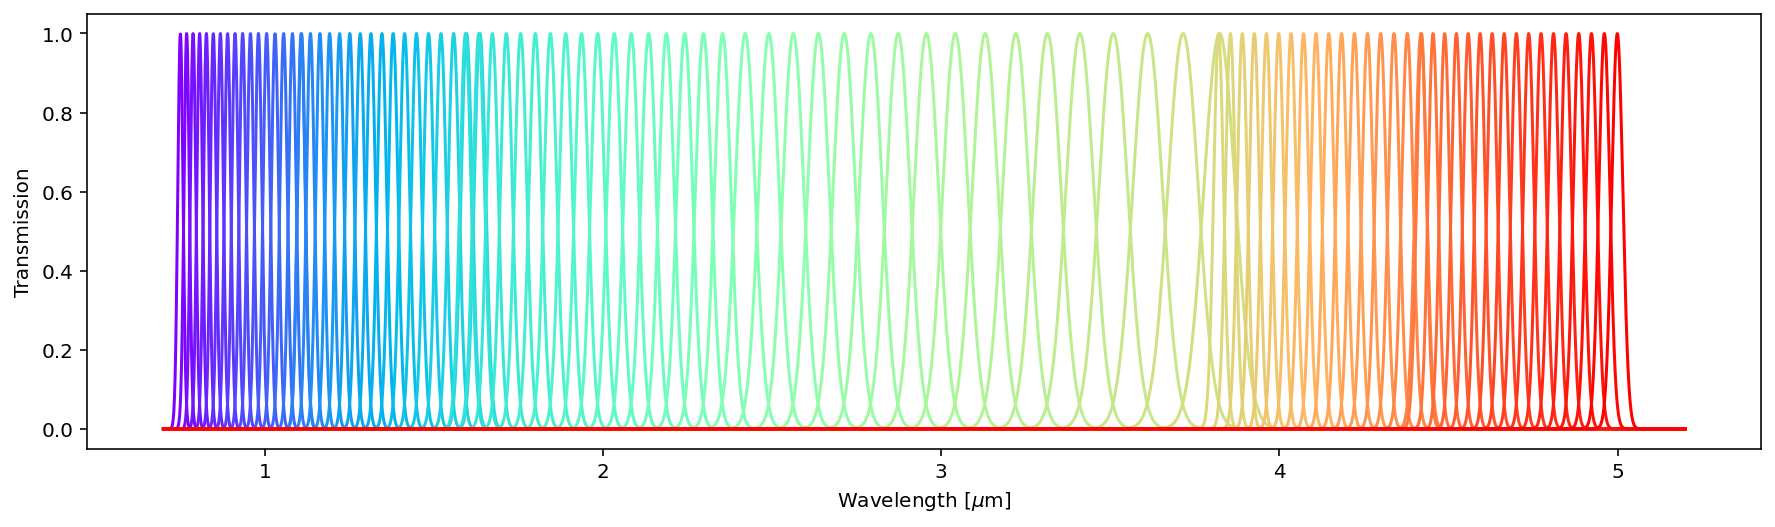

In [11]:
Nchan_total = 102
colors = plt.cm.rainbow(np.linspace(0, 1, Nchan_total))

def get_trans_band(band_start, Nchan, R):
    ichan = np.arange(Nchan)
    lcen  = band_start * ( (2*R+1)/(2*R-1) )**ichan  # Why?
    width = lcen / R
    return lcen, width

lmin1 = band1_start  # minimum wavelength [um]
Nchan1 = 17    # Number of independent resolution elements with the LVF
R1 = 41       # Resolving power at each LVF point

lcen1, width1 = get_trans_band(lmin1, Nchan1, R1)

lmin2, Nchan2, R2 = band2_start, 17, 41
lcen2, width2 = get_trans_band(lmin2, Nchan2, R2)

lmin3, Nchan3, R3 = band3_start, 17, 41
lcen3, width3 = get_trans_band(lmin3, Nchan3, R3)

lmin4, Nchan4, R4 = 2.42, 17, 35
lcen4, width4 = get_trans_band(lmin4, Nchan4, R4)

lmin5, Nchan5, R5 = 3.82, 17, 110
lcen5, width5 = get_trans_band(lmin5, Nchan5, R5)

lmin6, Nchan6, R6 = 4.42, 17, 130
lcen6, width6 = get_trans_band(lmin6, Nchan6, R6)

print(f'lambda center: {lcen1[-1]:.3f}, {lcen2[0]:.3f}, {lcen2[-1]:.3f}, {lcen3[0]:.3f}, {lcen3[-1]:.3f}, {lcen4[0]:.3f}, {lcen4[-1]:.3f}, {lcen5[0]:.3f}, {lcen5[-1]:.3f}, {lcen6[0]:.3f}, {lcen6[-1]:.3f}')

lcen = np.concatenate([lcen1, lcen2, lcen3, lcen4, lcen5, lcen6])
width = np.concatenate([width1, width2, width3, width4, width5, width6])

wvec = np.linspace(0.7, 5.2, 5001)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
for i, l, w in zip(np.arange(Nchan_total), lcen, width):
    prof = Gaussian1D(amplitude=1, mean=l, stddev=w/2.35)
    ax.plot(wvec, prof(wvec), c=colors[i])
ax.set_xlabel('Wavelength [$\mu$m]')
ax.set_ylabel('Transmission')

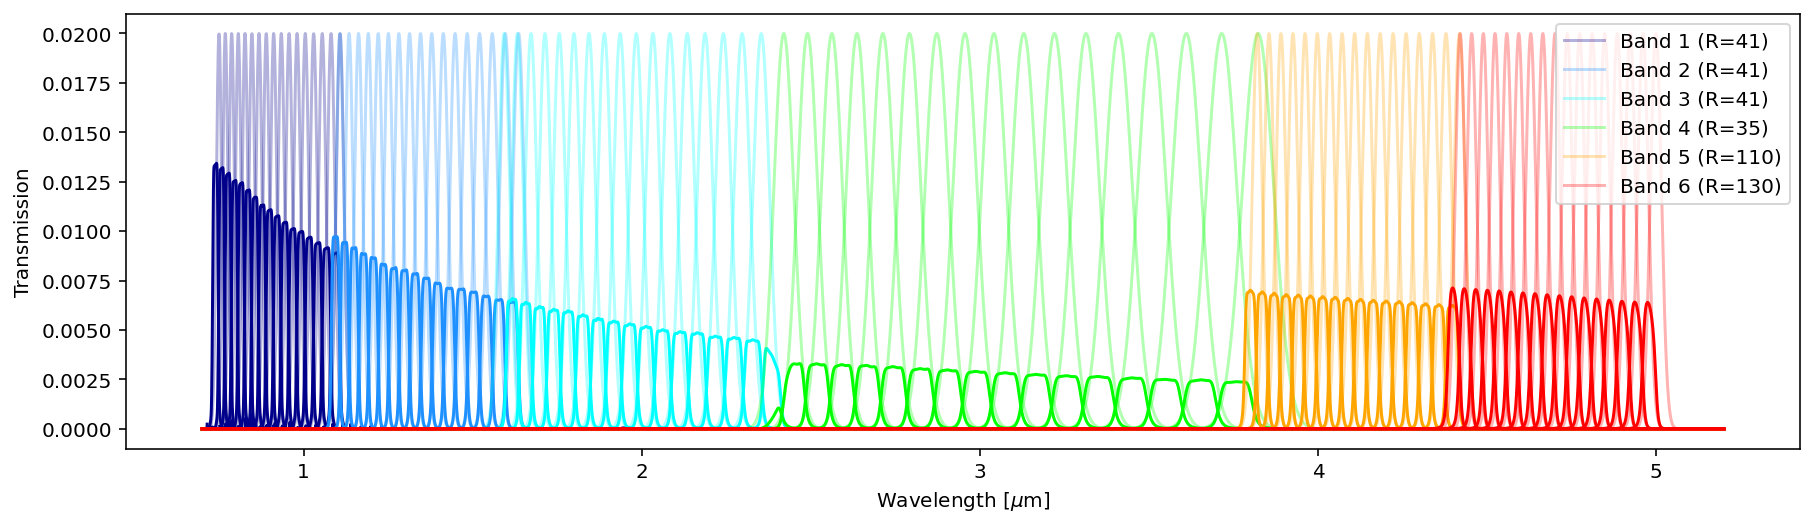

In [12]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)

llcen = [lcen1, lcen2, lcen3, lcen4, lcen5, lcen6]
lwidth = [width1, width2, width3, width4, width5, width6]
lNchan = [Nchan1, Nchan2, Nchan3, Nchan4, Nchan5, Nchan6]
lR = [R1, R2, R3, R4, R5, R6]
lcolor = ['darkblue', 'dodgerblue', 'cyan', 'lime', 'orange', 'red']
if Path('mock_lvf.res').exists():
    Path('mock_lvf.res').unlink()
if Path('mock_lvf.res.info').exists():
    Path('mock_lvf.res.info').unlink()
with open('mock_lvf.res', 'a') as f1:
    with open('mock_lvf.res.info', 'a') as f2:
        for j in range(6):
            _ichan = np.arange(lNchan[j])
            _lcen = llcen[j]
            _width = lwidth[j]
            _R = lR[j]
            _color = lcolor[j]
            for i, l, w in zip(_ichan, _lcen, _width):
                prof = Gaussian1D(amplitude=1, mean=l, stddev=w/2.35)
                tran = prof(wvec)
                filt = Table.read(f'../fiducial_filters_102/filt_det{j+1}_{i+1}.csv',
                                 format='ascii.no_header', names=['wave', 'throughput'])
                if i == 0:
                    ax.plot(wvec, tran/50, c=_color, label=f'Band {j+1} (R={_R})', alpha=0.3)
                else:
                    ax.plot(wvec, tran/50, c=_color, alpha=0.3)
                ax.plot(filt['wave']*1e-4, filt['throughput'], c=_color)
                wmask = filt['throughput'] > 1e-5
                res = filters.FilterDefinition(wave=filt['wave'][wmask],
                                               throughput=filt['throughput'][wmask],
                                               name=f'Band{j+1}_{i+1}')
                filter_str = res.for_filter_file()
                filter_name = filter_str.split('\n')[0]
                f1.write(filter_str + '\n')
                f2.write(filter_name + '\n')
ax.set_xlabel('Wavelength [$\mu$m]')
ax.set_ylabel('Transmission')
ax.legend()
        

In [9]:
latest_filters = filters.FilterFile(os.path.join(utils.path_to_eazy_data(), 'FILTER.RES.latest'))
i_u = latest_filters.search('Johnson_U')
i_b = latest_filters.search('Johnson_B')
i_v = latest_filters.search('Johnson_V')
i_j = latest_filters.search('2MASS/J')
i_k = latest_filters.search('2MASS/K')
i_ubvjk = list(np.concatenate([i_u, i_b, i_v, i_j, i_k]))

DEFAULT_RF_FILTERS = [270, 274] # UV tophat
DEFAULT_RF_FILTERS += [120, 121] # GALEX
DEFAULT_RF_FILTERS += [156, 157, 158, 159, 160] #SDSS
DEFAULT_RF_FILTERS += [161, 162, 163] # 2MASS
NUVRK_FILTERS = [121, 158, 163]
absmag_filters=[271, 272, 274]
additional_filters = np.unique(DEFAULT_RF_FILTERS + NUVRK_FILTERS + absmag_filters) - 1
append_filters = np.setdiff1d(additional_filters, i_ubvjk)

with open('ubvjk.res', 'w') as f:
    for i in i_ubvjk:
        f.write(latest_filters.filters[i].for_filter_file() + '\n')
    for i in append_filters:
        f.write(latest_filters.filters[i].for_filter_file() + '\n')

In [13]:
lvf_res = filters.FilterFile('mock_lvf.res')
ubvjk_res = filters.FilterFile('ubvjk.res')
for filter in ubvjk_res.filters:
    lvf_res.filters.append(filter)
lvf_res.write('test_lvf_ubvjk.res')

Wrote <test_lvf_ubvjk.res[.info]>


<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
/var/folders/c3/0f663kw90xldstvklyr5nq9c0000gn/T/ipykernel_29019/3636268046.py:21: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Wavelength [$\mu$m]')


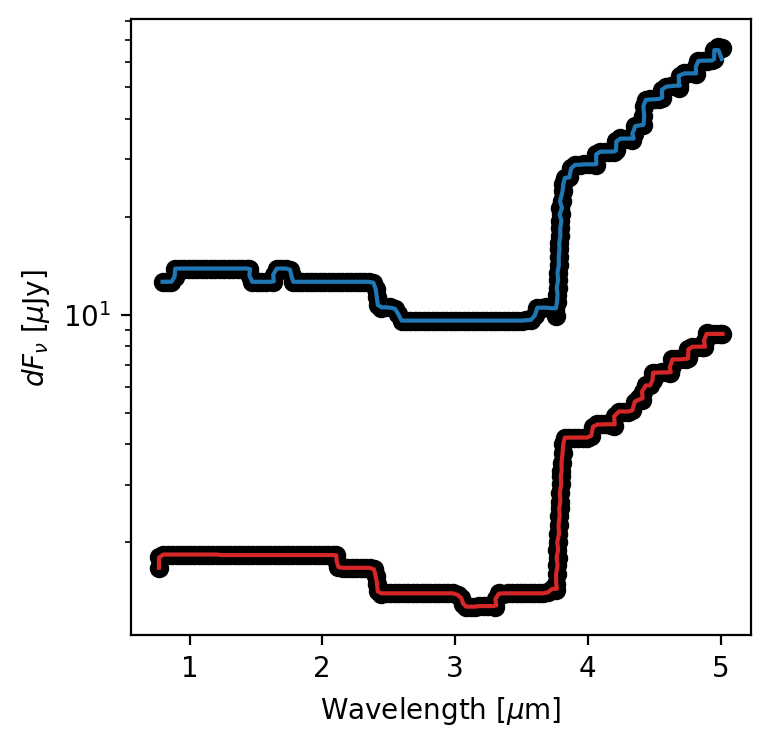

In [38]:
from astropy.table import Table
from scipy.signal import savgol_filter, medfilt

mev_fullsky = Table.read('../fullsky.csv', names=['wave', 'dfnu'])
mev_deep = Table.read('../deep.csv', names=['wave', 'dfnu'])

mev_fullsky['dfnu_smooth'] = savgol_filter(mev_fullsky['dfnu'], 5, 3)
mev_deep['dfnu_smooth'] = savgol_filter(mev_deep['dfnu'], 5, 3)

mev_fullsky['dfnu_med'] = medfilt(mev_fullsky['dfnu'], 5)
mev_deep['dfnu_med'] = medfilt(mev_deep['dfnu'], 5)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(mev_fullsky['wave'], mev_fullsky['dfnu'], 'ok', label='Full-sky')
ax.plot(mev_deep['wave'], mev_deep['dfnu'], 'ok', label='Deep')
# ax.plot(mev_fullsky['wave'], mev_fullsky['dfnu_smooth'], c='tab:blue')
# ax.plot(mev_deep['wave'], mev_deep['dfnu_smooth'], c='tab:red')
ax.plot(mev_fullsky['wave'], mev_fullsky['dfnu_med'], c='tab:blue')
ax.plot(mev_deep['wave'], mev_deep['dfnu_med'], c='tab:red')
ax.set_xlabel('Wavelength [$\mu$m]')
ax.set_ylabel(r'$dF_\nu$ [$\mu$Jy]')
ax.set_yscale('log')

<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
/var/folders/c3/0f663kw90xldstvklyr5nq9c0000gn/T/ipykernel_29019/2623594254.py:11: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Wavelength [$\mu$m]')


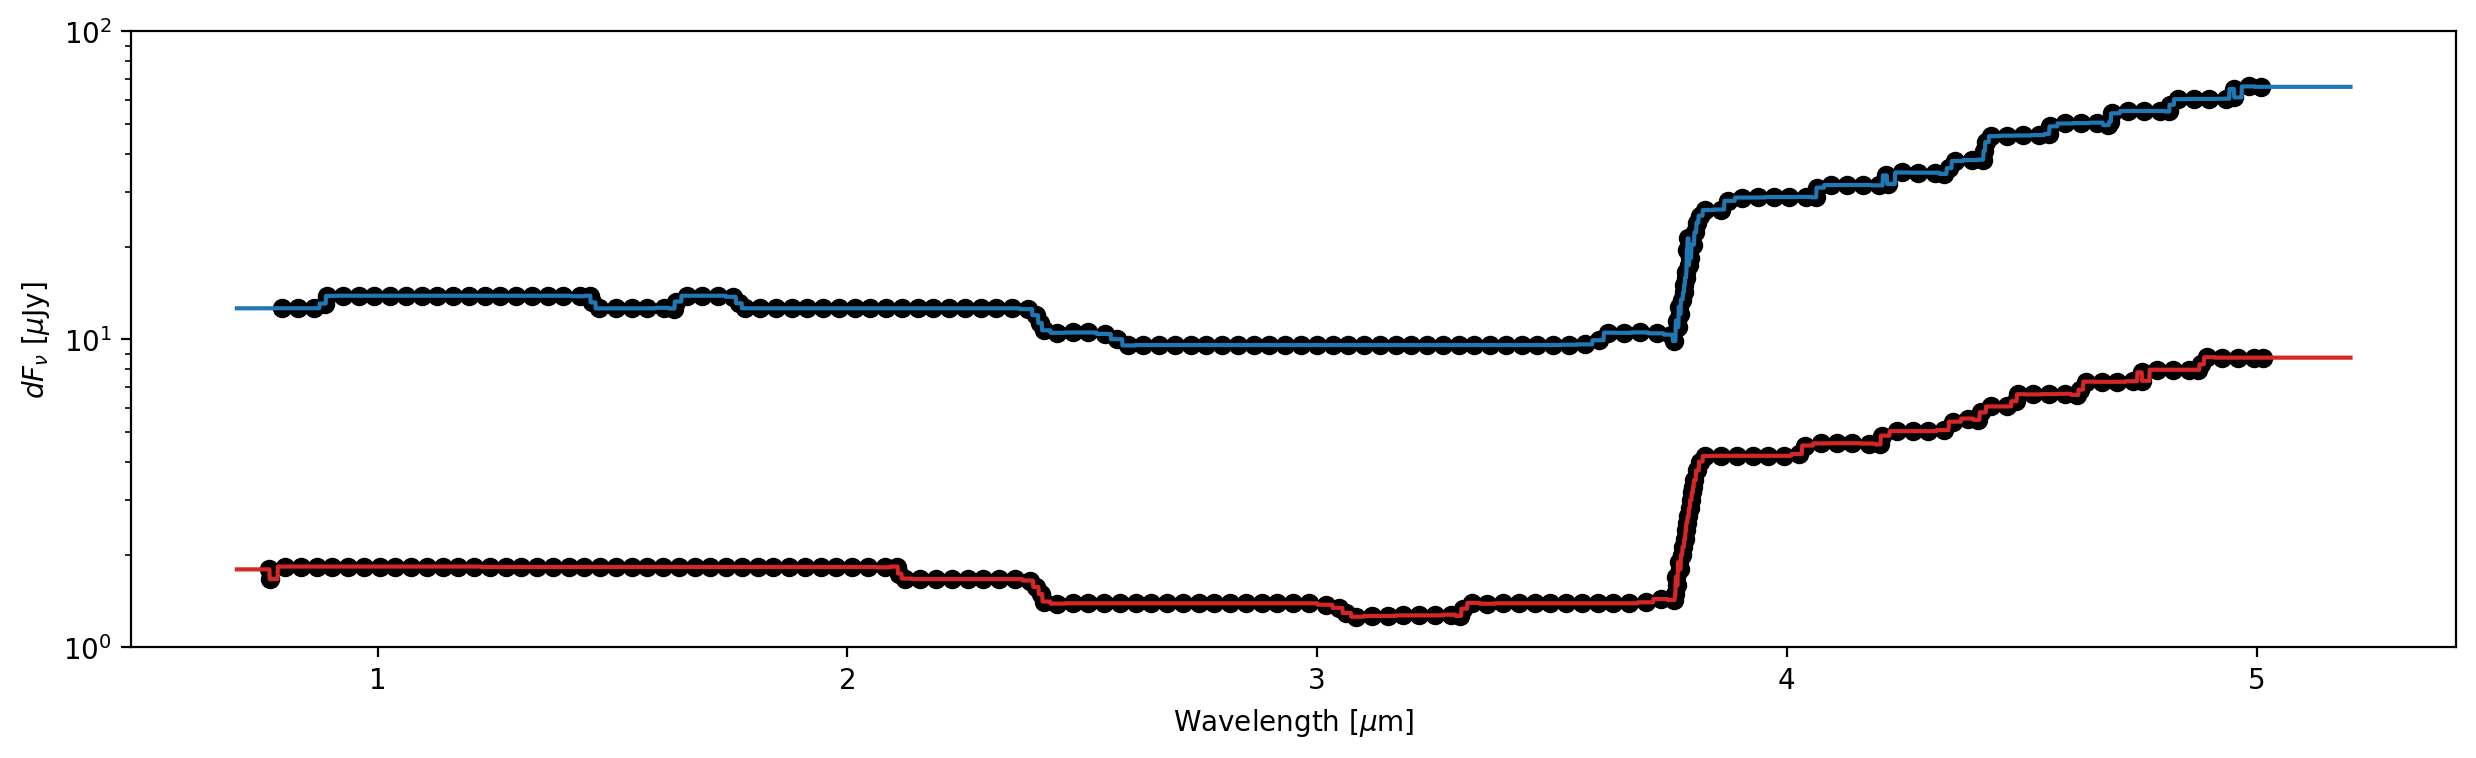

In [39]:
from scipy.interpolate import interp1d
mev_fs_interp = interp1d(mev_fullsky['wave'], mev_fullsky['dfnu'], kind='nearest', fill_value='extrapolate')
mev_deep_interp = interp1d(mev_deep['wave'], mev_deep['dfnu'], kind='nearest', fill_value='extrapolate')

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax.plot(mev_fullsky['wave'], mev_fullsky['dfnu'], 'ok', label='Full-sky')
ax.plot(mev_deep['wave'], mev_deep['dfnu'], 'ok', label='Deep')
ax.plot(wvec, mev_fs_interp(wvec), c='tab:blue', label='Full-sky')
ax.plot(wvec, mev_deep_interp(wvec), c='tab:red', label='Deep')
ax.set_xlabel('Wavelength [$\mu$m]')
ax.set_ylabel(r'$dF_\nu$ [$\mu$Jy]')
ax.set_ylim(1, 1e2)
ax.set_yscale('log')


<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/var/folders/c3/0f663kw90xldstvklyr5nq9c0000gn/T/ipykernel_29019/3296178572.py:6: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Wavelength [$\mu$m]')


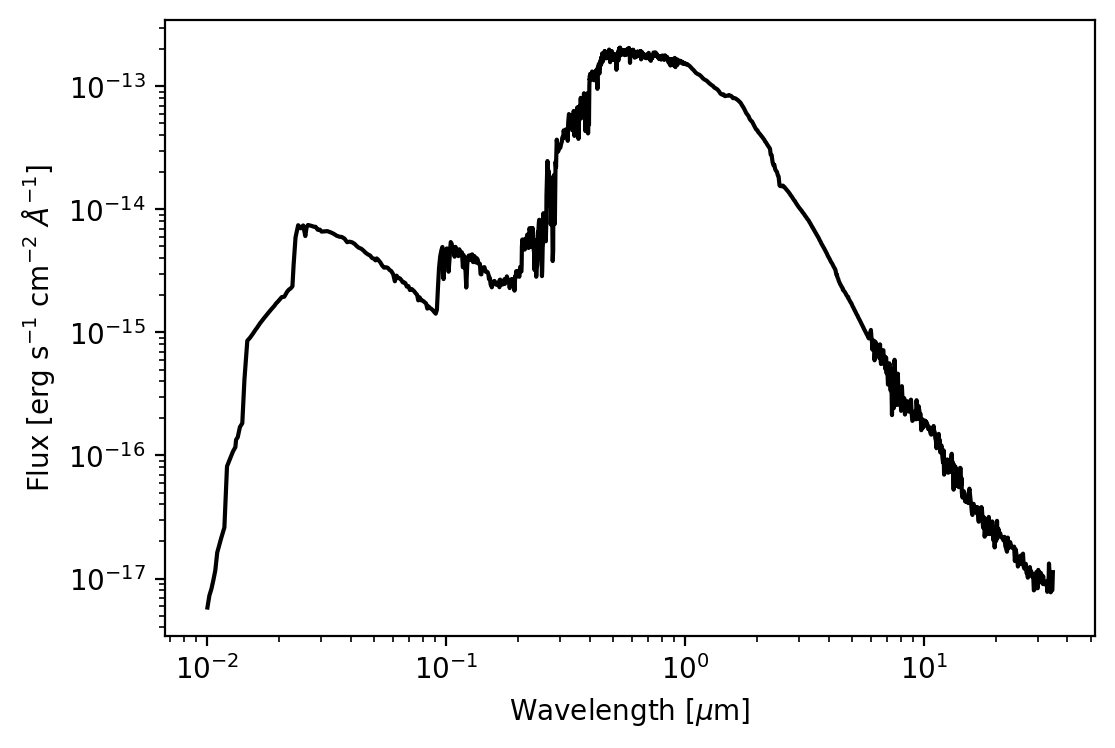

In [40]:
spec_example = Table.read('../NGC_0584_spec.dat', format='ascii', names=['wave', 'flux', 'wave_o', 'source'])

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(spec_example['wave']*1e-4, spec_example['flux'], 'k')
ax.set_xlabel('Wavelength [$\mu$m]')
ax.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')
ax.set_xscale('log')
ax.set_yscale('log')

In [41]:
def calculate_synthetic_flam(lam, flam, filter_lam, filter_trans):
    """Calculate the synthetic magnitude of a spectrum through a given filter."""
    # Interpolate spectrum and filter transmission to a common wavelength grid
    common_lam = np.linspace(max(min(lam), min(filter_lam)), 
                                     min(max(lam), max(filter_lam)), num=1000)
    flam_interp = np.interp(common_lam, lam, flam)
    trans_interp = np.interp(common_lam, filter_lam, filter_trans)

    # Calculate the flux received through the filter
    synthetic_flam = (np.trapz(flam_interp * trans_interp * common_lam, common_lam) / 
                      np.trapz(trans_interp * common_lam, common_lam))
    
    # Pivot wavelength
    pivot_lam = np.sqrt(np.trapz(common_lam * trans_interp, common_lam) /
                        np.trapz(trans_interp / common_lam, common_lam))
    
    return synthetic_flam, pivot_lam

In [42]:
names = []
eznames = []
i = 0
for band in range(1,7):
    for chan in range(1, 18):
        i += 1
        names.append(f'F{band}C{chan:02d}')
        names.append(f'E{band}C{chan:02d}')
        eznames.append(f'F{i}')
        eznames.append(f'E{i}')

print(names)
print(eznames)

translate = Table([names, eznames], names=['name', 'ezname'])
# no header
translate.write('test.translate', format='ascii.no_header', overwrite=True)

['F1C01', 'E1C01', 'F1C02', 'E1C02', 'F1C03', 'E1C03', 'F1C04', 'E1C04', 'F1C05', 'E1C05', 'F1C06', 'E1C06', 'F1C07', 'E1C07', 'F1C08', 'E1C08', 'F1C09', 'E1C09', 'F1C10', 'E1C10', 'F1C11', 'E1C11', 'F1C12', 'E1C12', 'F1C13', 'E1C13', 'F1C14', 'E1C14', 'F1C15', 'E1C15', 'F1C16', 'E1C16', 'F1C17', 'E1C17', 'F2C01', 'E2C01', 'F2C02', 'E2C02', 'F2C03', 'E2C03', 'F2C04', 'E2C04', 'F2C05', 'E2C05', 'F2C06', 'E2C06', 'F2C07', 'E2C07', 'F2C08', 'E2C08', 'F2C09', 'E2C09', 'F2C10', 'E2C10', 'F2C11', 'E2C11', 'F2C12', 'E2C12', 'F2C13', 'E2C13', 'F2C14', 'E2C14', 'F2C15', 'E2C15', 'F2C16', 'E2C16', 'F2C17', 'E2C17', 'F3C01', 'E3C01', 'F3C02', 'E3C02', 'F3C03', 'E3C03', 'F3C04', 'E3C04', 'F3C05', 'E3C05', 'F3C06', 'E3C06', 'F3C07', 'E3C07', 'F3C08', 'E3C08', 'F3C09', 'E3C09', 'F3C10', 'E3C10', 'F3C11', 'E3C11', 'F3C12', 'E3C12', 'F3C13', 'E3C13', 'F3C14', 'E3C14', 'F3C15', 'E3C15', 'F3C16', 'E3C16', 'F3C17', 'E3C17', 'F4C01', 'E4C01', 'F4C02', 'E4C02', 'F4C03', 'E4C03', 'F4C04', 'E4C04', 'F4C05', 

<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
/var/folders/c3/0f663kw90xldstvklyr5nq9c0000gn/T/ipykernel_29019/3272043224.py:49: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Wavelength [$\mu$m]')


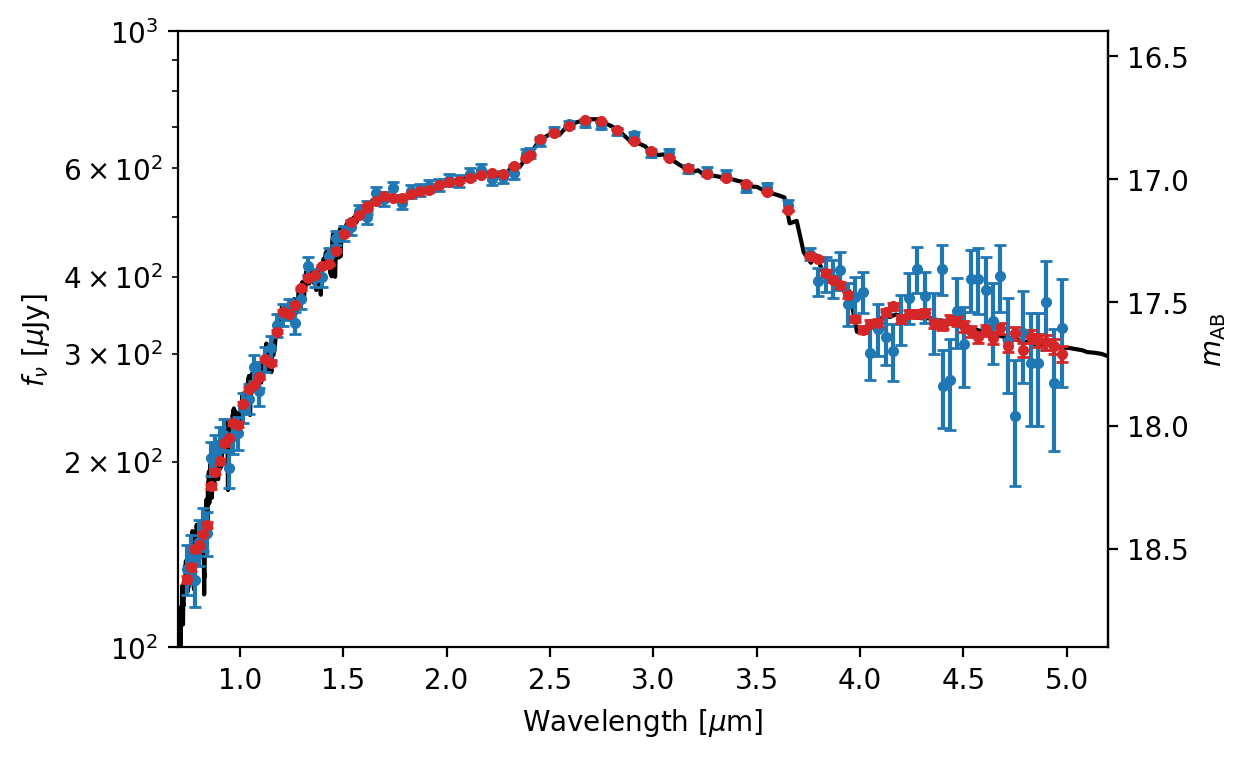

In [49]:
def flam_to_fnu(lam, flam):
    fnu = 3.34e4*lam**2*flam # in Jy
    return fnu * 1e6 # in uJy

def fnu_to_flam(lam, fnu):
    flam = fnu / (3.34e4*lam**2) # fnu in uJy
    return flam * 1e-6 # in erg/s/cm^2/A

scaling_factor = 1e-3
fiducial_redshift = 0.6

lam = spec_example['wave'] * (1+fiducial_redshift)
flam = spec_example['flux'] * scaling_factor / (1+fiducial_redshift)**2
fnu = flam_to_fnu(lam, flam) # in uJy

res = filters.FilterFile('test_lvf_ubvjk.res')

pivlam = np.zeros(Nchan_total)
syn_fnu_fs = np.zeros(Nchan_total)
syn_fnu_dp = np.zeros(Nchan_total)
syn_fnu = np.zeros(Nchan_total)
syn_fnu_error_fs = np.zeros(Nchan_total)
syn_fnu_error_dp = np.zeros(Nchan_total)
for i, f in zip(np.arange(Nchan_total), res.filters):
    wave, trans = f.wave, f.throughput
    syn_flam, pivot_lam = calculate_synthetic_flam(lam, flam, wave, trans)
    syn_fnu_anchor = flam_to_fnu(pivot_lam, syn_flam) # in uJy
    
    error_fs = mev_fs_interp(pivot_lam*1e-4)
    # syn_fnu_error_fs[i] = np.sqrt(error_fs**2 + syn_fnu_anchor)
    syn_fnu_error_fs[i] = np.sqrt(error_fs**2)
    error_dp = mev_deep_interp(pivot_lam*1e-4)
    # syn_fnu_error_dp[i] = np.sqrt(error_dp**2 + syn_fnu_anchor)
    syn_fnu_error_dp[i] = np.sqrt(error_dp**2)
    
    # update the synthetic flux
    # np.random.seed(101)
    syn_fnu_fs[i] = np.random.normal(syn_fnu_anchor, syn_fnu_error_fs[i])
    syn_fnu_dp[i] = np.random.normal(syn_fnu_anchor, syn_fnu_error_dp[i])
    pivlam[i] = pivot_lam
    syn_fnu[i] = syn_fnu_anchor
    
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(lam*1e-4, fnu, 'k')
ax.errorbar(pivlam*1e-4, syn_fnu_fs, yerr=syn_fnu_error_fs, fmt='o', c='tab:blue', label='Full-sky', ms=3, capsize=2)
ax.errorbar(pivlam*1e-4, syn_fnu_dp, yerr=syn_fnu_error_dp, fmt='o', c='tab:red', label='Deep', ms=3, capsize=2)
# ax.plot(pivlam*1e-4, syn_fnu, 'o', c='k', alpha=0.1)
ax.set_xlabel('Wavelength [$\mu$m]')
ax.set_ylabel(r'$f_\nu$ [$\mu$Jy]')
ax.set_xlim(0.7, 5.2)


ax.set_yscale('log')
ax.set_ylim(1e2, 1e3)
secax = ax.secondary_yaxis('right', functions=(lambda x: -2.5*np.log10(x*1e-6/3631), lambda x: 3631*1e6*10**(-0.4*x)))
# tick format
secax.set_ylabel(r'$m_{\rm AB}$')
secax.set_ticks([18.5, 18, 17.5, 17, 16.5])
from matplotlib.ticker import StrMethodFormatter, ScalarFormatter
secax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))

arr_fs = np.ravel(np.vstack([syn_fnu_fs, syn_fnu_error_fs]).T)
tab_fs = Table(arr_fs.T, names=names)
tab_fs['id'] = [0]
tab_fs.write('test_synphot_bright_fullsky.dat', format='ascii.commented_header', overwrite=True)

arr_dp = np.ravel(np.vstack([syn_fnu_dp, syn_fnu_error_dp]).T)
tab_dp = Table(arr_dp.T, names=names)
tab_dp['id'] = [0]
tab_dp.write('test_synphot_bright_deep.dat', format='ascii.commented_header', overwrite=True)

In [50]:
from astropy.table import vstack
tab_all = vstack([tab_fs, tab_dp])

<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
/var/folders/c3/0f663kw90xldstvklyr5nq9c0000gn/T/ipykernel_29019/847736025.py:49: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Wavelength [$\mu$m]')


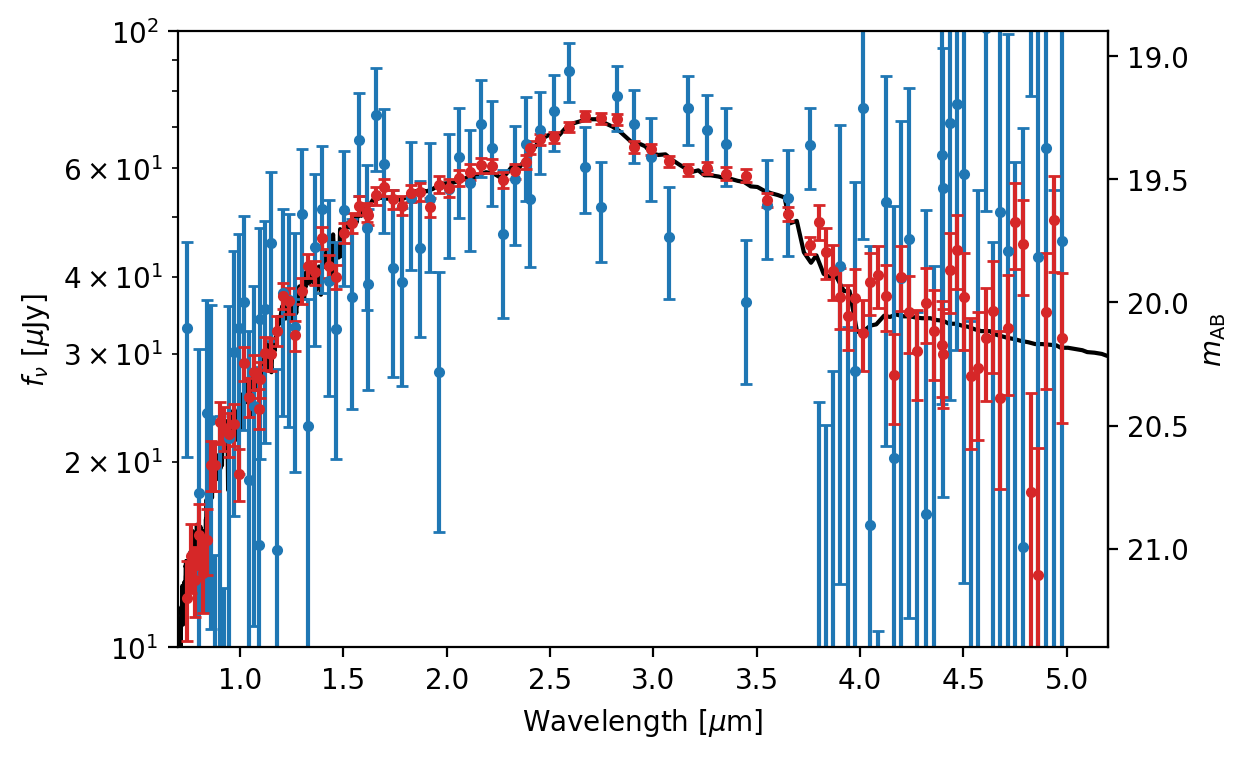

In [51]:
def flam_to_fnu(lam, flam):
    fnu = 3.34e4*lam**2*flam # in Jy
    return fnu * 1e6 # in uJy

def fnu_to_flam(lam, fnu):
    flam = fnu / (3.34e4*lam**2) # fnu in uJy
    return flam * 1e-6 # in erg/s/cm^2/A

scaling_factor = 1e-4
fiducial_redshift = 0.6

lam = spec_example['wave']*(1+fiducial_redshift)
flam = spec_example['flux'] * scaling_factor / (1+fiducial_redshift)**2
fnu = flam_to_fnu(lam, flam) # in uJy

res = filters.FilterFile('test_lvf_ubvjk.res')

pivlam = np.zeros(Nchan_total)
syn_fnu_fs = np.zeros(Nchan_total)
syn_fnu_dp = np.zeros(Nchan_total)
syn_fnu = np.zeros(Nchan_total)
syn_fnu_error_fs = np.zeros(Nchan_total)
syn_fnu_error_dp = np.zeros(Nchan_total)
for i, f in zip(np.arange(Nchan_total), res.filters):
    wave, trans = f.wave, f.throughput
    syn_flam, pivot_lam = calculate_synthetic_flam(lam, flam, wave, trans)
    syn_fnu_anchor = flam_to_fnu(pivot_lam, syn_flam) # in uJy
    
    error_fs = mev_fs_interp(pivot_lam*1e-4)
    # syn_fnu_error_fs[i] = np.sqrt(error_fs**2 + syn_fnu_anchor)
    syn_fnu_error_fs[i] = np.sqrt(error_fs**2)
    error_dp = mev_deep_interp(pivot_lam*1e-4)
    # syn_fnu_error_dp[i] = np.sqrt(error_dp**2 + syn_fnu_anchor)
    syn_fnu_error_dp[i] = np.sqrt(error_dp**2)
    
    # update the synthetic flux
    # np.random.seed(101)
    syn_fnu_fs[i] = np.random.normal(syn_fnu_anchor, syn_fnu_error_fs[i])
    syn_fnu_dp[i] = np.random.normal(syn_fnu_anchor, syn_fnu_error_dp[i])
    pivlam[i] = pivot_lam
    syn_fnu[i] = syn_fnu_anchor
    
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(lam*1e-4, fnu, 'k')
ax.errorbar(pivlam*1e-4, syn_fnu_fs, yerr=syn_fnu_error_fs, fmt='o', c='tab:blue', label='Full-sky', ms=3, capsize=2)
ax.errorbar(pivlam*1e-4, syn_fnu_dp, yerr=syn_fnu_error_dp, fmt='o', c='tab:red', label='Deep', ms=3, capsize=2)
# ax.plot(pivlam*1e-4, syn_fnu, 'o', c='k', alpha=0.1)
ax.set_xlabel('Wavelength [$\mu$m]')
ax.set_ylabel(r'$f_\nu$ [$\mu$Jy]')
ax.set_xlim(0.7, 5.2)


ax.set_yscale('log')
ax.set_ylim(1e1, 1e2)
secax = ax.secondary_yaxis('right', functions=(lambda x: -2.5*np.log10(x*1e-6/3631), lambda x: 3631*1e6*10**(-0.4*x)))
# tick format
secax.set_ylabel(r'$m_{\rm AB}$')
secax.set_ticks([21, 20.5, 20, 19.5, 19, 18.5, 18])
from matplotlib.ticker import StrMethodFormatter, ScalarFormatter
secax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
# ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))

    
arr_fs = np.ravel(np.vstack([syn_fnu_fs, syn_fnu_error_fs]).T)
tab_fs = Table(arr_fs.T, names=names)
tab_fs['id'] = [0]
tab_fs.write('test_synphot_faint_fullsky.dat', format='ascii.commented_header', overwrite=True)

arr_dp = np.ravel(np.vstack([syn_fnu_dp, syn_fnu_error_dp]).T)
tab_dp = Table(arr_dp.T, names=names)
tab_dp['id'] = [0]
tab_dp.write('test_synphot_faint_deep.dat', format='ascii.commented_header', overwrite=True)

In [102]:
tab_all = vstack([tab_all, tab_fs, tab_dp])

In [104]:
tab_all['id'] = np.arange(len(tab_all))
tab_all.write('test_synphot_all.dat', format='ascii.commented_header', overwrite=True)